# Заливка

Нужно обновить sqlite3, чтобы были доступны все функции, например оконные.

In [ ]:
!wget https://www.sqlite.org/src/tarball/sqlite.tar.gz?r=release -O sqlite.tar.gz
!tar xzf sqlite.tar.gz
%cd sqlite/
!./configure
!make sqlite3.c
%cd /content
!npx degit coleifer/pysqlite3 -f
!cp sqlite/sqlite3.[ch] .
!python setup.py build_static build
!cp build/lib.linux-x86_64-3.6/pysqlite3/_sqlite3.cpython-36m-x86_64-linux-gnu.so \
    /usr/lib/python3.6/lib-dynload/_sqlite3.cpython-36m-x86_64-linux-gnu.so
# then MENU: Runtime > Restart runtime ...

--2020-11-26 06:37:30--  https://www.sqlite.org/src/tarball/sqlite.tar.gz?r=release
Resolving www.sqlite.org (www.sqlite.org)... 45.33.6.223, 2600:3c00::f03c:91ff:fe96:b959
Connecting to www.sqlite.org (www.sqlite.org)|45.33.6.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11075165 (11M) [application/x-compressed]
Saving to: ‘sqlite.tar.gz’

sqlite.tar.gz       100%[===================>]  10.56M  40.1MB/s    in 0.3s    

2020-11-26 06:37:31 (40.1 MB/s) - ‘sqlite.tar.gz’ saved [11075165/11075165]

/content/sqlite
checking build system type... x86_64-pc-linux-gnu
checking host system type... x86_64-pc-linux-gnu
checking for gcc... gcc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
chec

## Теперь обязательно Runtime->Restart Runtime

In [ ]:
import sqlite3

In [ ]:
sqlite3.sqlite_version

'3.33.0'

На текущий момент (2020-11) 3.33.0 это последний релиз. https://www.sqlite.org/news.html

In [ ]:
import pandas as pd
import numpy as np

У меня данные https://www.kaggle.com/carrie1/ecommerce-data лежат на Google Drive.

In [ ]:
!ls 'drive/My Drive/data'

afisha					 megaline
bank.csv				 mf-accelerator
bank_score.csv				 ml-20m
credit_scoring_eng.csv			 mushrooms.csv
credit_scoring_eng_processed.csv	 real_estate_data.csv
datasets_32132_205932_telecom_churn.csv  real_estate_data_eng.csv
ecommerce-data.zip			 rotten-tomatoes
gold_recovery				 telecom_practicum


In [ ]:
df = pd.read_csv('drive/My Drive/data/ecommerce-data.zip',encoding='cp1252')

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Чтобы потом не гемориться переведем дату в тип дата здесь, в питоне. И в sqlite уже все будет ок.

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%m/%d/%Y %H:%M')

Теперь создадим 1) саму базу и подключкние к ней 2) курсор -- понадобится чтобы создавить таблички 3) функцию обертку для того чтобы быстро писать селекты

In [ ]:
conn = sqlite3.connect('db')
cur = conn.cursor()

In [ ]:
def select(sql):
  return pd.read_sql(sql,conn)

Теперь зальем таблу и проверим, что все ок

In [ ]:
df.to_sql('ecommerce',conn,index=False,if_exists='replace')

In [ ]:
sql = '''select count(*) from ecommerce t'''

In [ ]:
select(sql)

,count(*)
0,541909


In [ ]:
len(df)

541909

In [ ]:
sql = '''select * from ecommerce t limit 5'''

In [ ]:
select(sql)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
select(sql).dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Все четко, можно работать.

# Анализ

recency frequency monetary  

r (как давно что-то покупал? Чем более недавно, тем лучше) 1-4  
f (как часто покупал ранее? Чем чаще, тем лучше) 1-4  
m (как много денег потратил на нас? Чем больше, тем лучше) 1-4  

rfm = (r + f + m) / 3

111
112

In [ ]:
sql = '''select

date(t.InvoiceDate,'start of month'),
count(*)

from ecommerce t 
group by date(t.InvoiceDate,'start of month')
order by date(t.InvoiceDate,'start of month')
'''

In [ ]:
select(sql)

,"date(t.InvoiceDate,'start of month')",count(*)
0,2010-12-01,42481
1,2011-01-01,35147
2,2011-02-01,27707
3,2011-03-01,36748
4,2011-04-01,29916
5,2011-05-01,37030
6,2011-06-01,36874
7,2011-07-01,39518
8,2011-08-01,35284
9,2011-09-01,50226


In [ ]:
sql = '''select max(t.InvoiceDate) from ecommerce t'''

In [ ]:
select(sql)

,max(t.InvoiceDate)
0,2011-12-09 12:50:00


In [ ]:
sql = '''select

t.CustomerID,
min(t.InvoiceDate) as reg_date,
sum(t.Quantity * t.UnitPrice) as revenue


from ecommerce t 
where date(t.InvoiceDate,'start of month') <= '2011-10-01'
and t.CustomerID is not null
group by t.CustomerID
'''

In [ ]:
t = select(sql)

In [ ]:
t

,CustomerID,reg_date,revenue
0,12346.0,2011-01-18 10:01:00,0.00
1,12347.0,2010-12-07 14:57:00,4085.18
2,12348.0,2010-12-16 19:09:00,1797.24
3,12350.0,2011-02-02 16:01:00,334.40
4,12352.0,2011-02-16 12:33:00,1233.68
...,...,...,...
4005,18280.0,2011-03-07 09:52:00,180.60
4006,18281.0,2011-06-12 10:53:00,80.82
4007,18282.0,2011-08-05 13:35:00,98.76
4008,18283.0,2011-01-06 14:14:00,1235.32


In [ ]:
t[t['revenue'] < 0]

,CustomerID,reg_date,revenue
81,12454.0,2011-10-14 17:13:00,-5.684342e-14
114,12503.0,2011-01-06 11:51:00,-1.126000e+03
115,12505.0,2011-02-11 13:39:00,-4.500000e+00
176,12586.0,2010-12-06 09:31:00,-1.700000e+01
192,12605.0,2010-12-09 15:41:00,-7.500000e+00
237,12666.0,2010-12-15 14:42:00,-2.274400e+02
382,12870.0,2010-12-08 14:27:00,-1.490000e+01
429,12943.0,2011-02-11 15:13:00,-3.750000e+00
569,13154.0,2011-07-18 15:21:00,-6.118600e+02
918,13672.0,2011-01-10 12:02:00,-7.146000e+01


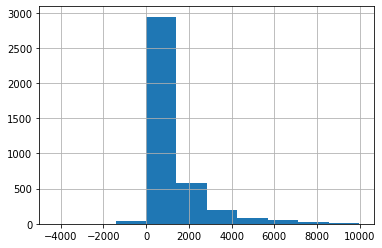

In [ ]:
t[t['revenue']<10000]['revenue'].hist()

In [ ]:
t[t['revenue']<50000].median()

CustomerID    15276.00
revenue         602.09
dtype: float64

In [ ]:
len(t[t['revenue']<10000]['revenue']) / len(t)

0.9812967581047382

In [ ]:
sql = '''

drop table if exists customer;

create table customer as

select t.*,
date('2011-11-01') as month,

julianday(date('2011-11-01')) - julianday(t.last_purchase) as recency

from

(select

t.CustomerID,
min(t.InvoiceDate) as reg_date,
max(t.InvoiceDate) as last_purchase,
sum(t.Quantity * t.UnitPrice) as monetary,
count(distinct t.InvoiceNo) as frequency



from ecommerce t 
where date(t.InvoiceDate,'start of month') <= '2011-10-01'
and t.CustomerID is not null
group by t.CustomerID) t
where t.monetary < 10000
'''

In [ ]:
cur.executescript(sql)

In [ ]:
sql = '''select t.CustomerID, sum(t.Quantity * t.UnitPrice) as target 
from ecommerce t
where date(t.InvoiceDate,'start of month') == '2011-11-01'
group by  t.CustomerID
'''

In [ ]:
select(sql)

,CustomerID,target
0,NaN,3.293485e+05
1,12349.0,1.757550e+03
2,12352.0,3.117300e+02
3,12356.0,5.835000e+01
4,12357.0,6.207670e+03
...,...,...
1707,18263.0,3.996800e+02
1708,18270.0,1.712000e+02
1709,18274.0,1.243450e-14
1710,18276.0,-1.250000e+01


In [ ]:
sql = '''select t.*, n.target from customer t
left join (select t.CustomerID, sum(t.Quantity * t.UnitPrice) as target 
from ecommerce t
where date(t.InvoiceDate,'start of month') == '2011-11-01'
group by  t.CustomerID) n on t.CustomerID = n.CustomerID

'''

In [ ]:
select(sql)

,CustomerID,reg_date,last_purchase,monetary,frequency,month,recency,target
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:17:00,0.00,2,2011-11-01,286.571528,NaN
1,12347.0,2010-12-07 14:57:00,2011-10-31 12:25:00,4085.18,6,2011-11-01,0.482639,NaN
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,1797.24,4,2011-11-01,36.449306,NaN
3,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,334.40,1,2011-11-01,271.332639,NaN
4,12352.0,2011-02-16 12:33:00,2011-09-28 14:58:00,1233.68,10,2011-11-01,33.376389,311.73
...,...,...,...,...,...,...,...,...
3930,18280.0,2011-03-07 09:52:00,2011-03-07 09:52:00,180.60,1,2011-11-01,238.588889,NaN
3931,18281.0,2011-06-12 10:53:00,2011-06-12 10:53:00,80.82,1,2011-11-01,141.546528,NaN
3932,18282.0,2011-08-05 13:35:00,2011-08-09 15:10:00,98.76,2,2011-11-01,83.368056,NaN
3933,18283.0,2011-01-06 14:14:00,2011-10-27 14:38:00,1235.32,11,2011-11-01,4.390278,651.56


In [ ]:
t = select(sql)

recency frequency monetary  

r (как давно что-то покупал? Чем более недавно, тем лучше) 1-4  
f (как часто покупал ранее? Чем чаще, тем лучше) 1-4  
m (как много денег потратил на нас? Чем больше, тем лучше) 1-4  

In [ ]:
t

,CustomerID,reg_date,last_purchase,monetary,frequency,month,recency,target
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:17:00,0.00,2,2011-11-01,286.571528,NaN
1,12347.0,2010-12-07 14:57:00,2011-10-31 12:25:00,4085.18,6,2011-11-01,0.482639,NaN
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,1797.24,4,2011-11-01,36.449306,NaN
3,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,334.40,1,2011-11-01,271.332639,NaN
4,12352.0,2011-02-16 12:33:00,2011-09-28 14:58:00,1233.68,10,2011-11-01,33.376389,311.73
...,...,...,...,...,...,...,...,...
3930,18280.0,2011-03-07 09:52:00,2011-03-07 09:52:00,180.60,1,2011-11-01,238.588889,NaN
3931,18281.0,2011-06-12 10:53:00,2011-06-12 10:53:00,80.82,1,2011-11-01,141.546528,NaN
3932,18282.0,2011-08-05 13:35:00,2011-08-09 15:10:00,98.76,2,2011-11-01,83.368056,NaN
3933,18283.0,2011-01-06 14:14:00,2011-10-27 14:38:00,1235.32,11,2011-11-01,4.390278,651.56


In [ ]:
t['recency']

0       286.571528
1         0.482639
2        36.449306
3       271.332639
4        33.376389
           ...    
3930    238.588889
3931    141.546528
3932     83.368056
3933      4.390278
3934      3.604861
Name: recency, Length: 3935, dtype: float64

In [ ]:
t['r'] = 5 - (pd.qcut(t['recency'],4,labels=False) + 1)

In [ ]:
t.groupby('r')['recency'].agg(['mean','count'])

,mean,count
r,,
1,238.929315,984
2,97.578577,983
3,34.175226,984
4,9.272108,984


In [ ]:
t['f'] = pd.qcut(t['frequency'],4,labels=False,duplicates='drop') + 2

In [ ]:
t.groupby('f')['frequency'].agg(['mean','count'])

,mean,count
f,,
2,1.367202,2116
3,3.808654,1040
4,10.928113,779


In [ ]:
t.groupby('f')['frequency'].agg(set)

f
2                                               {1, 2}
3                                            {3, 4, 5}
4    {6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...
Name: frequency, dtype: object

In [ ]:
t['frequency'].value_counts()

1     1339
2      777
3      461
4      317
5      262
6      152
7      115
8       96
9       66
10      62
11      55
13      34
12      33
14      27
15      21
16      20
17      13
19      10
20       9
24       9
21       8
18       8
25       7
23       6
22       5
26       4
28       3
31       3
35       2
38       2
40       2
34       1
36       1
33       1
76       1
27       1
29       1
74       1
Name: frequency, dtype: int64

In [ ]:
def get_f(x):
  if x == 1:
    return 1
  if x in [2,3]:
    return 2
  if x in [3,4,5,6]:
    return 3
  return 4 

In [ ]:
t['f'] = t['frequency'].apply(get_f)

In [ ]:
t.groupby('f')['frequency'].agg(['mean','count'])

,mean,count
f,,
1,1.000000,1339
2,2.372375,1238
3,4.774282,731
4,12.122807,627


In [ ]:
t['m'] = pd.qcut(t['monetary'],4,labels=False) + 1

In [ ]:
t.groupby('m')['monetary'].agg(['mean','count'])

,mean,count
m,,
1,138.807317,984
2,401.886477,984
3,894.042645,983
4,3012.871109,984


In [ ]:
t['rfm_score'] = (t['r'] + t['f'] + t['m']) / 3

In [ ]:
t.sort_values('rfm_score',ascending=False)

,CustomerID,reg_date,last_purchase,monetary,frequency,month,recency,target,r,f,m,rfm_score
1172,14085.0,2010-12-06 12:39:00,2011-10-25 16:20:00,3525.98,15,2011-11-01,6.319444,278.82,4,4,4,4.0
1187,14112.0,2011-03-09 11:28:00,2011-10-30 16:00:00,2613.15,10,2011-11-01,1.333333,161.02,4,4,4,4.0
2113,15505.0,2011-07-07 13:33:00,2011-10-18 07:56:00,3497.14,7,2011-11-01,13.669444,NaN,4,4,4,4.0
2098,15482.0,2010-12-16 10:08:00,2011-10-25 17:32:00,2503.50,8,2011-11-01,6.269444,4065.22,4,4,4,4.0
3337,17365.0,2011-01-11 12:11:00,2011-10-20 12:07:00,4375.19,7,2011-11-01,11.495139,426.37,4,4,4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2475,16061.0,2011-03-15 14:41:00,2011-03-15 14:41:00,-29.95,1,2011-11-01,230.388194,NaN,1,1,1,1.0
3533,17670.0,2011-04-26 09:12:00,2011-04-26 09:12:00,205.70,1,2011-11-01,188.616667,NaN,1,1,1,1.0
2484,16078.0,2011-03-01 09:47:00,2011-03-01 09:47:00,79.20,1,2011-11-01,244.592361,NaN,1,1,1,1.0
2497,16097.0,2011-04-13 13:47:00,2011-04-13 13:47:00,185.05,1,2011-11-01,201.425694,NaN,1,1,1,1.0


https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17

In [ ]:
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'

In [ ]:
t['RFM_Score'] = (t['r'] + t['f'] + t['m'])

In [ ]:
t['segment'] = t.apply(rfm_level,axis=1)

In [ ]:
t.groupby('segment')['monetary'].agg(['mean','count'])

,mean,count
segment,,
Can't Loose Them,2399.799870,1307
Champions,979.344811,418
Loyal,656.788071,476
Needs Attention,230.661849,438
Potential,456.758162,500
Promising,332.846186,409
Require Activation,133.005271,387


recency frequency monetary  

r (как давно что-то покупал? Чем более недавно, тем лучше) 1-4  
f (как часто покупал ранее? Чем чаще, тем лучше) 1-4  
m (как много денег потратил на нас? Чем больше, тем лучше) 1-4  

In [ ]:
t['recency'].rank(pct=True,ascending=False)

0       0.055909
1       0.992630
2       0.593393
3       0.077510
4       0.628208
          ...   
3930    0.113850
3931    0.275476
3932    0.400508
3933    0.940661
3934    0.952732
Name: recency, Length: 3935, dtype: float64

In [ ]:
d = pd.DataFrame([1,2,3,4,4,4,5,6])

In [ ]:
d['rnk'] = d[0].rank(method='max')

In [ ]:
d

,0,rnk
0,1,1.0
1,2,2.0
2,3,3.0
3,4,6.0
4,4,6.0
5,4,6.0
6,5,7.0
7,6,8.0


In [ ]:
t['r_pct'] = t['recency'].rank(pct=True,ascending=False)
t['f_pct'] = t['frequency'].rank(pct=True)
t['m_pct'] = t['monetary'].rank(pct=True)

In [ ]:
t['rfm_pct'] = t[['r_pct','f_pct','m_pct']].sum(axis=1)

In [ ]:
t

,CustomerID,reg_date,last_purchase,monetary,frequency,month,recency,target,r,f,m,rfm_score,RFM_Score,segment,r_pct,f_pct,m_pct,rfm_pct
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:17:00,0.00,2,2011-11-01,286.571528,NaN,1,2,1,1.333333,4,Needs Attention,0.055909,0.439136,0.012706,0.507751
1,12347.0,2010-12-07 14:57:00,2011-10-31 12:25:00,4085.18,6,2011-11-01,0.482639,NaN,4,3,4,3.666667,11,Can't Loose Them,0.992630,0.821474,0.950445,2.764549
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,1797.24,4,2011-11-01,36.449306,NaN,3,3,4,3.333333,10,Can't Loose Them,0.593393,0.695299,0.816773,2.105464
3,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,334.40,1,2011-11-01,271.332639,NaN,1,1,2,1.333333,4,Needs Attention,0.077510,0.170267,0.326048,0.573825
4,12352.0,2011-02-16 12:33:00,2011-09-28 14:58:00,1233.68,10,2011-11-01,33.376389,311.73,3,4,3,3.333333,10,Can't Loose Them,0.628208,0.919060,0.723761,2.271029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3930,18280.0,2011-03-07 09:52:00,2011-03-07 09:52:00,180.60,1,2011-11-01,238.588889,NaN,1,1,1,1.000000,3,Require Activation,0.113850,0.170267,0.155527,0.439644
3931,18281.0,2011-06-12 10:53:00,2011-06-12 10:53:00,80.82,1,2011-11-01,141.546528,NaN,2,1,1,1.333333,4,Needs Attention,0.275476,0.170267,0.039898,0.485642
3932,18282.0,2011-08-05 13:35:00,2011-08-09 15:10:00,98.76,2,2011-11-01,83.368056,NaN,2,2,1,1.666667,5,Promising,0.400508,0.439136,0.052605,0.892249
3933,18283.0,2011-01-06 14:14:00,2011-10-27 14:38:00,1235.32,11,2011-11-01,4.390278,651.56,4,4,3,3.666667,11,Can't Loose Them,0.940661,0.933926,0.724269,2.598856


In [ ]:
sql = '''
select t.r,count(1) from

(select t.*,

ntile(4) over (order by t.recency desc) as r


 from customer t) t
 group by t.r
 
 '''

In [ ]:
select(sql)

,r,count(1)
0,1,984
1,2,984
2,3,984
3,4,983


In [ ]:
sql = '''
select t.f,count(1),
group_concat(distinct t.frequency)

 from

(select t.*,

ntile(4) over (order by t.frequency) as f


 from customer t) t
 group by t.f
 
 '''

In [ ]:
select(sql)

,f,count(1),group_concat(distinct t.frequency)
0,1,984,1
1,2,984,"1,2"
2,3,984,"2,3,4,5"
3,4,983,"5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,..."


In [ ]:
t

,CustomerID,reg_date,last_purchase,monetary,frequency,month,recency,target,r,f,m,rfm_score,RFM_Score,segment,r_pct,f_pct,m_pct,rfm_pct
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:17:00,0.00,2,2011-11-01,286.571528,NaN,1,2,1,1.333333,4,Needs Attention,0.055909,0.439136,0.012706,0.507751
1,12347.0,2010-12-07 14:57:00,2011-10-31 12:25:00,4085.18,6,2011-11-01,0.482639,NaN,4,3,4,3.666667,11,Can't Loose Them,0.992630,0.821474,0.950445,2.764549
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,1797.24,4,2011-11-01,36.449306,NaN,3,3,4,3.333333,10,Can't Loose Them,0.593393,0.695299,0.816773,2.105464
3,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,334.40,1,2011-11-01,271.332639,NaN,1,1,2,1.333333,4,Needs Attention,0.077510,0.170267,0.326048,0.573825
4,12352.0,2011-02-16 12:33:00,2011-09-28 14:58:00,1233.68,10,2011-11-01,33.376389,311.73,3,4,3,3.333333,10,Can't Loose Them,0.628208,0.919060,0.723761,2.271029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3930,18280.0,2011-03-07 09:52:00,2011-03-07 09:52:00,180.60,1,2011-11-01,238.588889,NaN,1,1,1,1.000000,3,Require Activation,0.113850,0.170267,0.155527,0.439644
3931,18281.0,2011-06-12 10:53:00,2011-06-12 10:53:00,80.82,1,2011-11-01,141.546528,NaN,2,1,1,1.333333,4,Needs Attention,0.275476,0.170267,0.039898,0.485642
3932,18282.0,2011-08-05 13:35:00,2011-08-09 15:10:00,98.76,2,2011-11-01,83.368056,NaN,2,2,1,1.666667,5,Promising,0.400508,0.439136,0.052605,0.892249
3933,18283.0,2011-01-06 14:14:00,2011-10-27 14:38:00,1235.32,11,2011-11-01,4.390278,651.56,4,4,3,3.666667,11,Can't Loose Them,0.940661,0.933926,0.724269,2.598856


In [ ]:
t.pivot_table(index='f',columns='r',values='monetary',aggfunc='sum')

r,1,2,3,4
f,,,,
1,173455.080,93840.87,103849.131,71046.26
2,149795.381,266158.92,234848.141,201137.25
3,63802.860,287989.92,386605.081,346290.83
4,27635.610,230306.10,639572.730,1099217.62


In [ ]:
t.groupby(['f','r'])['monetary'].sum().reset_index()

,f,r,monetary
0,1,1,173455.080
1,1,2,93840.870
2,1,3,103849.131
3,1,4,71046.260
4,2,1,149795.381
5,2,2,266158.920
6,2,3,234848.141
7,2,4,201137.250
8,3,1,63802.860
9,3,2,287989.920


In [ ]:
t.pivot_table(index='f',columns='r',values='monetary',aggfunc='sum')

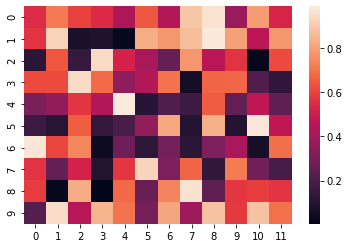

In [ ]:
import numpy as np; np.random.seed(0)
import seaborn as sns
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(uniform_data)

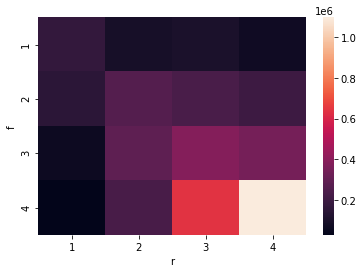

In [ ]:
sns.heatmap(t.pivot_table(index='f',columns='r',values='monetary',aggfunc='sum'))

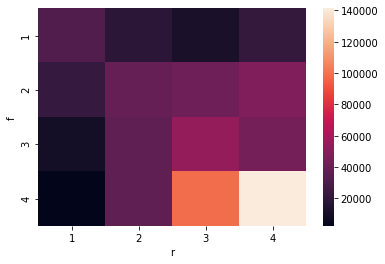

In [ ]:
sns.heatmap(t.pivot_table(index='f',columns='r',values='target',aggfunc='sum'))

In [ ]:
t['has_purchase'] = (t['target'] > 0) * 1

In [ ]:
t['has_purchase'].mean()

0.3232528589580686

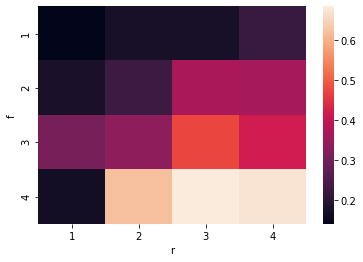

In [ ]:
sns.heatmap(t.pivot_table(index='f',columns='r',values='has_purchase',aggfunc='mean'))

In [ ]:
t.pivot_table(index='f',columns='r',values='has_purchase',aggfunc='mean')

r,1,2,3,4
f,,,,
1,0.139647,0.175258,0.173729,0.222222
2,0.175862,0.225131,0.367893,0.363296
3,0.305085,0.334884,0.474359,0.417040
4,0.166667,0.621053,0.683721,0.672131


In [ ]:
t

,CustomerID,reg_date,last_purchase,monetary,frequency,month,recency,target,r,f,m,rfm_score,RFM_Score,segment,r_pct,f_pct,m_pct,rfm_pct,has_purchase
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:17:00,0.00,2,2011-11-01,286.571528,NaN,1,2,1,1.333333,4,Needs Attention,0.055909,0.439136,0.012706,0.507751,0
1,12347.0,2010-12-07 14:57:00,2011-10-31 12:25:00,4085.18,6,2011-11-01,0.482639,NaN,4,3,4,3.666667,11,Can't Loose Them,0.992630,0.821474,0.950445,2.764549,0
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,1797.24,4,2011-11-01,36.449306,NaN,3,3,4,3.333333,10,Can't Loose Them,0.593393,0.695299,0.816773,2.105464,0
3,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,334.40,1,2011-11-01,271.332639,NaN,1,1,2,1.333333,4,Needs Attention,0.077510,0.170267,0.326048,0.573825,0
4,12352.0,2011-02-16 12:33:00,2011-09-28 14:58:00,1233.68,10,2011-11-01,33.376389,311.73,3,4,3,3.333333,10,Can't Loose Them,0.628208,0.919060,0.723761,2.271029,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3930,18280.0,2011-03-07 09:52:00,2011-03-07 09:52:00,180.60,1,2011-11-01,238.588889,NaN,1,1,1,1.000000,3,Require Activation,0.113850,0.170267,0.155527,0.439644,0
3931,18281.0,2011-06-12 10:53:00,2011-06-12 10:53:00,80.82,1,2011-11-01,141.546528,NaN,2,1,1,1.333333,4,Needs Attention,0.275476,0.170267,0.039898,0.485642,0
3932,18282.0,2011-08-05 13:35:00,2011-08-09 15:10:00,98.76,2,2011-11-01,83.368056,NaN,2,2,1,1.666667,5,Promising,0.400508,0.439136,0.052605,0.892249,0
3933,18283.0,2011-01-06 14:14:00,2011-10-27 14:38:00,1235.32,11,2011-11-01,4.390278,651.56,4,4,3,3.666667,11,Can't Loose Them,0.940661,0.933926,0.724269,2.598856,1


In [ ]:
t['has_purchase'].sum()

1272

In [ ]:
len(t)

3935

In [ ]:
t.sample(frac=0.2)['has_purchase'].sum()/t['has_purchase'].sum()

0.18396226415094338

In [ ]:
t.sort_values('rfm_score',ascending=False,inplace=True)

In [ ]:
t

,CustomerID,reg_date,last_purchase,monetary,frequency,month,recency,target,r,f,m,rfm_score,RFM_Score,segment,r_pct,f_pct,m_pct,rfm_pct,has_purchase
1172,14085.0,2010-12-06 12:39:00,2011-10-25 16:20:00,3525.98,15,2011-11-01,6.319444,278.82,4,4,4,4.0,12,Can't Loose Them,0.908259,0.967471,0.934435,2.810165,1
1187,14112.0,2011-03-09 11:28:00,2011-10-30 16:00:00,2613.15,10,2011-11-01,1.333333,161.02,4,4,4,4.0,12,Can't Loose Them,0.984244,0.919060,0.889962,2.793266,1
2113,15505.0,2011-07-07 13:33:00,2011-10-18 07:56:00,3497.14,7,2011-11-01,13.669444,NaN,4,4,4,4.0,12,Can't Loose Them,0.809911,0.855400,0.933418,2.598729,0
2098,15482.0,2010-12-16 10:08:00,2011-10-25 17:32:00,2503.50,8,2011-11-01,6.269444,4065.22,4,4,4,4.0,12,Can't Loose Them,0.909530,0.882211,0.883100,2.674841,1
3337,17365.0,2011-01-11 12:11:00,2011-10-20 12:07:00,4375.19,7,2011-11-01,11.495139,426.37,4,4,4,4.0,12,Can't Loose Them,0.844473,0.855400,0.957814,2.657687,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,16061.0,2011-03-15 14:41:00,2011-03-15 14:41:00,-29.95,1,2011-11-01,230.388194,NaN,1,1,1,1.0,3,Require Activation,0.125794,0.170267,0.007116,0.303177,0
3533,17670.0,2011-04-26 09:12:00,2011-04-26 09:12:00,205.70,1,2011-11-01,188.616667,NaN,1,1,1,1.0,3,Require Activation,0.191105,0.170267,0.181703,0.543075,0
2484,16078.0,2011-03-01 09:47:00,2011-03-01 09:47:00,79.20,1,2011-11-01,244.592361,NaN,1,1,1,1.0,3,Require Activation,0.104956,0.170267,0.038374,0.313596,0
2497,16097.0,2011-04-13 13:47:00,2011-04-13 13:47:00,185.05,1,2011-11-01,201.425694,NaN,1,1,1,1.0,3,Require Activation,0.174079,0.170267,0.159085,0.503431,0


In [ ]:
0.2 * len(t)

787.0

In [ ]:
t.head(round(0.2 * len(t)))['has_purchase'].sum()/t['has_purchase'].sum()

0.375

In [ ]:
t.head(round(0.2 * len(t)))['has_purchase'].sum()/t['has_purchase'].sum() / 0.2

1.875

In [ ]:
!pip install scikit-plot

In [ ]:
from scikitplot.helpers import cumulative_gain_curve

In [ ]:
per, gain = cumulative_gain_curve(t['has_purchase'],t['rfm_score'])
lc = pd.DataFrame({'per':per,'gain':gain})
lc['random'] = lc['per']
_, ideal = cumulative_gain_curve(t['has_purchase'],t['has_purchase'])
lc['ideal'] = ideal

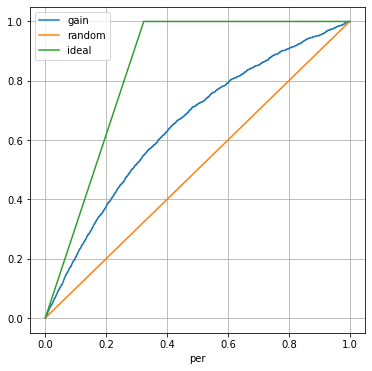

In [ ]:
lc.plot(x='per',y=['gain','random','ideal'],figsize=(6,6),grid=True)

In [ ]:
t['has_purchase'].mean()

0.3232528589580686

In [ ]:
from sklearn.metrics import auc

In [ ]:
model_auc = auc(lc['per'],lc['gain']) - 0.5
ideal_auc = auc(lc['per'],lc['ideal']) - 0.5
gini = model_auc / ideal_auc

In [ ]:
gini

0.43762413885129803

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
rocuac = roc_auc_score(t['has_purchase'],t['rfm_score'])

In [ ]:
2 * rocuac - 1

0.43442457435577686

In [ ]:
gini

0.43762413885129803

Не совпадает потому что скоры не уникальные. Можно добавить шум, и увидеть, что все работает.

In [ ]:
t['rfm_score'].value_counts()

2.000000    500
2.333333    476
1.333333    438
2.666667    418
1.666667    409
1.000000    387
3.000000    374
3.333333    348
3.666667    309
4.000000    276
Name: rfm_score, dtype: int64

In [ ]:
np.random.uniform(size=len(t)) / 10000000

array([5.04684497e-09, 4.50937988e-08, 3.21117495e-08, ...,
       6.66324515e-08, 9.94100140e-08, 3.51277707e-08])

In [ ]:
t['rfm_score_noise'] = t['rfm_score'] + (np.random.uniform(size=len(t)) / 10000000)

In [ ]:
per, gain = cumulative_gain_curve(t['has_purchase'],t['rfm_score_noise'])
lc = pd.DataFrame({'per':per,'gain':gain})
lc['random'] = lc['per']
_, ideal = cumulative_gain_curve(t['has_purchase'],t['has_purchase'])
lc['ideal'] = ideal

In [ ]:
model_auc = auc(lc['per'],lc['gain']) - 0.5
ideal_auc = auc(lc['per'],lc['ideal']) - 0.5
gini = model_auc / ideal_auc

In [ ]:
gini

0.4358770431985489

In [ ]:
rocuac = roc_auc_score(t['has_purchase'],t['rfm_score_noise'])

In [ ]:
2 * rocuac - 1

0.43587704319854903